In [ ]:
# using Kernal PyTorch-1.7.1
# using Kernal PyTorch-1.7.1
# using Kernal PyTorch-1.7.1 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit # train_test_split, 
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')


%run utility.py

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Main Homo-Sapiens Classification Algorightm

### Build ANN model

In [2]:
# Define the MLP model (from previous examples)
class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, num_classes):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

### Training

In [3]:
# Training and validation loop
def  trainModel(model, train_loader, val_loader):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        
        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
    
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
    
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
    
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')
    
    
    print('Training completed.')
    return model

### Overall Evaluate

In [4]:
def Overall_Evaluate(model, test_loader):
    # Evaluation on test data
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = correct / total
    print(f'Accuracy on test data: {accuracy * 100:.2f}%')

### Accuracty Evaluation Breakdown

In [5]:
def Breakdown_Evaluate(model, test_loader):
    model.eval()  # Set model to evaluation mode
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Update total count for each class
            for i in range(targets.size(0)):
                label = targets[i]
                class_total[label] += 1
                class_correct[label] += (predicted[i] == label).item()

    acc_data=[]
    
    # Calculate and print accuracy for each class
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = class_correct[i] / class_total[i]
            print(f'Accuracy of class {i}: {accuracy * 100:.2f}%')
            acc_data.append(accuracy)
        else:
            print(f'No samples for class {i} in the test set.')

    return acc_data

### AUC(Area Under the Curve) Evaluation Breakdown

In [6]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

def Breakdown_Evaluate_AUC(model, test_loader):
    model.eval()  # Set model to evaluation mode
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            
            # Get model outputs and apply softmax to get class probabilities
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)  # Probabilities for each class
            
            # Collect all targets and probabilities
            all_targets.append(targets.cpu())
            all_outputs.append(probabilities.cpu())
    
    # Concatenate all batches
    all_targets = torch.cat(all_targets)
    all_outputs = torch.cat(all_outputs)

    auc_data = []
    
    # Compute AUC for each class (one-vs-rest)
    for i in range(num_classes):
        # Binarize the targets for class 'i'
        binarized_targets = (all_targets == i).int()  # 1 if target is 'i', else 0
        
        # Get the predicted probabilities for class 'i'
        class_probabilities = all_outputs[:, i]
        
        # Compute AUC for class 'i'
        if len(set(binarized_targets.tolist())) > 1:  # Ensure we have both classes in the test set
            auc = roc_auc_score(binarized_targets, class_probabilities)
            print(f'AUC of class {i}: {auc:.2f}')
            auc_data.append(auc)
            
        else:
            print(f'Not enough data for class {i} to compute AUC.')
    
    return auc_data



### Hyperparameters

In [10]:
hidden_size1 = 120
hidden_size2 = 64
num_classes = 7
num_epochs = 20
batch_size = 32
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

### Accuracy Records

In [11]:
columns = [f'class{i}' for i in range(7)]  
df_acc_nt = pd.DataFrame(columns=columns)
df_acc_gpn = pd.DataFrame(columns=columns)
df_acc_dnabert2 = pd.DataFrame(columns=columns)
df_acc_hyena = pd.DataFrame(columns=columns)
df_acc_caduceus = pd.DataFrame(columns=columns)

### T-Test Records

In [12]:
columns = [f'class{i}' for i in range(7)]  
df_auc_nt = pd.DataFrame(columns=columns)
df_auc_gpn = pd.DataFrame(columns=columns)
df_auc_dnabert2 = pd.DataFrame(columns=columns)
df_auc_hyena = pd.DataFrame(columns=columns)
df_auc_caduceus = pd.DataFrame(columns=columns)

runcount=10

### split dataframe into 3 parts

In [14]:
def run_test(runcount, model, train_loader,val_loader, test_loader, df_acc, df_auc):
    
    for i in range(0, runcount):
        model = trainModel(model, train_loader,val_loader)
        
        Overall_Evaluate(model, test_loader)
    
        acc_data=Breakdown_Evaluate(model,test_loader)
        df_acc.loc[len(df_acc)] = acc_data  
        
        auc_data = Breakdown_Evaluate_AUC(model,test_loader)
        df_auc.loc[len(df_auc)] = auc_data

    return df_acc, df_auc

### Filter 

In [15]:
def filter(dfA,dfB):
    return dfA[dfA[['ROWID']].isin(dfB[['ROWID']].to_dict(orient='list')).all(axis=1)]

### Dataframe to dataloader

In [16]:
def df2dataloader(df_train, df_val, df_test):

    X_train, y_train = df_train.iloc[:, :-1].values, df_train.iloc[:, -1].values
    X_val, y_val = df_val.iloc[:, :-1].values, df_val.iloc[:, -1].values
    X_test, y_test = df_test.iloc[:, :-1].values, df_test.iloc[:, -1].values

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # assuming labels are integers
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # adjust batch_size as needed
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)     # shuffle can be False for validation
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)   # shuffle can be False for testing

    
    return train_loader, val_loader, test_loader


### Set base directory for embedding file

In [17]:
base_dir = '../embeddings/homo-sapiens/embedding-csv/'

### NT

In [18]:
def to_dataloader(X, y, batch_size=32, shuffle=True):
    # Convert NumPy arrays to PyTorch tensors
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.long)
    
    # Create TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)
    
    # Create DataLoader
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return loader
    

def load_embedding_file_NT(csv_filename):

    df=pd.read_csv(csv_filename)
    
    column_names = [f'{i}' for i in range(0, df.shape[1]-2)]
    column_names.extend(['ROWID',  'y']) 
    df.columns = column_names
    
    # Split the dataframe into features (X) and labels (y)
    features = df.iloc[:, :-1]  
    labels = df.iloc[:, -1]     
    
    # Initialize Stratified Shuffle Split
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=None)
    
    for train_index, test_index in split.split(features, labels):
        # Use pandas indexing to split data
        X_train_val, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train_val, y_test = labels.iloc[train_index], labels.iloc[test_index]
    
    # Now split the training set into training and validation sets
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=None)
    
    for train_index, val_index in split.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
        y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]    
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    # return df



def One_Run_NT(input_size, df_acc_nt, df_auc_nt):
    
    X_train_df, X_val_df, X_test_df, y_train, y_val, y_test =  load_embedding_file_NT(base_dir + 'homo_sapiens_nt_embedding.csv') 
    
    dropcolumnns=['ROWID'] 
    X_train = X_train_df.drop(dropcolumnns, axis=1)
    X_val   = X_val_df.drop(dropcolumnns, axis=1)
    X_test  = X_test_df.drop(dropcolumnns, axis=1)
    
    train_loader = to_dataloader(X_train, y_train)
    val_loader = to_dataloader(X_val, y_val)
    test_loader = to_dataloader(X_test, y_test)
    
    model = TwoLayerMLP(input_size, hidden_size1,hidden_size2,  num_classes).to(device)    

    df_acc_nt, df_auc_nt = run_test(1,model, train_loader,val_loader, test_loader, df_acc_nt, df_auc_nt)
    return df_acc_nt, df_auc_nt, X_train_df, X_val_df, X_test_df
    

df_acc_nt, df_auc_nt, X_train_df, X_val_df, X_test_df = One_Run_NT(1280, df_acc_nt, df_auc_nt)

print(len(X_train_df))
print(len(X_val_df))
print(len(X_test_df))

print(df_acc_nt)
print('\n')
print(df_auc_nt)

Epoch [1/20], Loss: 1.4462, Val Loss: 1.2357, Val Accuracy: 50.49%
Epoch [2/20], Loss: 1.2391, Val Loss: 1.2013, Val Accuracy: 52.72%
Epoch [3/20], Loss: 1.2154, Val Loss: 1.2107, Val Accuracy: 50.93%
Epoch [4/20], Loss: 1.1837, Val Loss: 1.1546, Val Accuracy: 53.92%
Epoch [5/20], Loss: 1.1630, Val Loss: 1.1781, Val Accuracy: 52.53%
Epoch [6/20], Loss: 1.1508, Val Loss: 1.1624, Val Accuracy: 53.55%
Epoch [7/20], Loss: 1.1313, Val Loss: 1.1193, Val Accuracy: 55.79%
Epoch [8/20], Loss: 1.1177, Val Loss: 1.1226, Val Accuracy: 55.75%
Epoch [9/20], Loss: 1.1125, Val Loss: 1.0936, Val Accuracy: 56.38%
Epoch [10/20], Loss: 1.1005, Val Loss: 1.1146, Val Accuracy: 55.99%
Epoch [11/20], Loss: 1.0991, Val Loss: 1.1117, Val Accuracy: 55.35%
Epoch [12/20], Loss: 1.1000, Val Loss: 1.1874, Val Accuracy: 50.22%
Epoch [13/20], Loss: 1.1255, Val Loss: 1.1887, Val Accuracy: 52.39%
Epoch [14/20], Loss: 1.1103, Val Loss: 1.1102, Val Accuracy: 54.44%
Epoch [15/20], Loss: 1.0960, Val Loss: 1.1182, Val Accura

##  load embedding file

In [20]:
def load_embedding_file(csv_filename, X_train_df,X_val_df,X_test_df):

    df=pd.read_csv(csv_filename)
    
    column_names = [f'{i}' for i in range(0, df.shape[1]-2)]
    column_names.extend(['ROWID', 'y'])
    df.columns = column_names
                   
    df_train= filter(df, X_train_df)
    df_val  = filter(df, X_val_df)
    df_test = filter(df, X_test_df)

    dropcolumns=['ROWID']
    df_train= df_train.drop(dropcolumns, axis=1) 
    df_val  = df_val.drop(dropcolumns, axis=1) 
    df_test = df_test.drop(dropcolumns, axis=1) 

    return df2dataloader(df_train, df_val, df_test)

### GPN

In [21]:
def One_Run_GPN(input_size, df_acc, df_auc):

    train_loader, val_loader, test_loader=load_embedding_file(base_dir + 'homo_sapiens_gpn_embedding.csv', X_train_df,X_val_df,X_test_df)   
    model = TwoLayerMLP(input_size, hidden_size1,hidden_size2,  num_classes).to(device)    
    df_acc, df_auc = run_test(1,model, train_loader,val_loader, test_loader, df_acc, df_auc)
    return df_acc, df_auc

# input_size = 768
df_acc_gpn, df_auc_gpn = One_Run_GPN(768, df_acc_gpn, df_auc_gpn)

print(df_acc_gpn)
print('\n')
print(df_auc_gpn)

Epoch [1/20], Loss: 1.1378, Val Loss: 1.0099, Val Accuracy: 60.69%
Epoch [2/20], Loss: 1.0054, Val Loss: 0.9805, Val Accuracy: 61.63%
Epoch [3/20], Loss: 0.9716, Val Loss: 0.9608, Val Accuracy: 62.86%
Epoch [4/20], Loss: 0.9415, Val Loss: 0.9948, Val Accuracy: 62.40%
Epoch [5/20], Loss: 0.9270, Val Loss: 0.9557, Val Accuracy: 63.15%
Epoch [6/20], Loss: 0.9079, Val Loss: 0.9308, Val Accuracy: 63.70%
Epoch [7/20], Loss: 0.8907, Val Loss: 1.0121, Val Accuracy: 61.87%
Epoch [8/20], Loss: 0.8739, Val Loss: 0.9046, Val Accuracy: 64.79%
Epoch [9/20], Loss: 0.8574, Val Loss: 0.9068, Val Accuracy: 64.89%
Epoch [10/20], Loss: 0.8490, Val Loss: 0.9314, Val Accuracy: 64.72%
Epoch [11/20], Loss: 0.8396, Val Loss: 0.8944, Val Accuracy: 64.65%
Epoch [12/20], Loss: 0.8283, Val Loss: 0.9436, Val Accuracy: 63.24%
Epoch [13/20], Loss: 0.8141, Val Loss: 0.9037, Val Accuracy: 64.99%
Epoch [14/20], Loss: 0.8082, Val Loss: 0.8870, Val Accuracy: 65.78%
Epoch [15/20], Loss: 0.8034, Val Loss: 0.9031, Val Accura

### DNABERT2

In [22]:
def One_Run_DNABERT2(input_size, df_acc, df_auc):

    train_loader, val_loader, test_loader=load_embedding_file(base_dir + 'homo_sapiens_dnabert2_embedding.csv', X_train_df,X_val_df,X_test_df)    
    model = TwoLayerMLP(input_size, hidden_size1,hidden_size2,  num_classes).to(device)    
    df_acc, df_auc = run_test(1,model, train_loader,val_loader, test_loader, df_acc, df_auc)
    return df_acc, df_auc

# input_size = 768
df_acc_dnabert2, df_auc_dnabert2 = One_Run_DNABERT2(768, df_acc_dnabert2, df_auc_dnabert2)

print(df_acc_dnabert2)
print('\n')
print(df_auc_dnabert2)

Epoch [1/20], Loss: 1.2090, Val Loss: 1.0510, Val Accuracy: 59.21%
Epoch [2/20], Loss: 0.9806, Val Loss: 1.0205, Val Accuracy: 60.76%
Epoch [3/20], Loss: 0.9102, Val Loss: 0.9602, Val Accuracy: 62.75%
Epoch [4/20], Loss: 0.8530, Val Loss: 0.9375, Val Accuracy: 63.62%
Epoch [5/20], Loss: 0.8037, Val Loss: 0.9534, Val Accuracy: 63.28%
Epoch [6/20], Loss: 0.7613, Val Loss: 0.9646, Val Accuracy: 63.44%
Epoch [7/20], Loss: 0.7216, Val Loss: 0.9783, Val Accuracy: 62.85%
Epoch [8/20], Loss: 0.6758, Val Loss: 1.0260, Val Accuracy: 62.59%
Epoch [9/20], Loss: 0.6343, Val Loss: 1.0014, Val Accuracy: 63.48%
Epoch [10/20], Loss: 0.5901, Val Loss: 1.0058, Val Accuracy: 63.75%
Epoch [11/20], Loss: 0.5422, Val Loss: 1.0738, Val Accuracy: 62.81%
Epoch [12/20], Loss: 0.4990, Val Loss: 1.1036, Val Accuracy: 62.88%
Epoch [13/20], Loss: 0.4610, Val Loss: 1.1443, Val Accuracy: 62.20%
Epoch [14/20], Loss: 0.4200, Val Loss: 1.2495, Val Accuracy: 62.09%
Epoch [15/20], Loss: 0.3855, Val Loss: 1.2745, Val Accura

### HyenaDNA

In [23]:
def One_Run_HYENADNA(input_size, df_acc, df_auc):

    train_loader, val_loader, test_loader=load_embedding_file(base_dir + 'homo_sapiens_hyena_embedding.csv', X_train_df,X_val_df,X_test_df)    
    model = TwoLayerMLP(input_size, hidden_size1,hidden_size2,  num_classes).to(device)    
    df_acc, df_auc = run_test(1,model,train_loader,val_loader, test_loader, df_acc, df_auc)
    return df_acc, df_auc

# input_size = 256
df_acc_hyena, df_auc_hyena = One_Run_HYENADNA(256, df_acc_hyena, df_auc_hyena)

print(df_acc_hyena)
print('\n')
print(df_auc_hyena)

Epoch [1/20], Loss: 1.6007, Val Loss: 1.5001, Val Accuracy: 38.29%
Epoch [2/20], Loss: 1.4561, Val Loss: 1.4261, Val Accuracy: 41.59%
Epoch [3/20], Loss: 1.4210, Val Loss: 1.4113, Val Accuracy: 41.78%
Epoch [4/20], Loss: 1.4099, Val Loss: 1.4811, Val Accuracy: 42.34%
Epoch [5/20], Loss: 1.3920, Val Loss: 1.3831, Val Accuracy: 42.87%
Epoch [6/20], Loss: 1.3795, Val Loss: 1.3776, Val Accuracy: 44.44%
Epoch [7/20], Loss: 1.3684, Val Loss: 1.3576, Val Accuracy: 45.50%
Epoch [8/20], Loss: 1.3610, Val Loss: 1.4098, Val Accuracy: 41.25%
Epoch [9/20], Loss: 1.3569, Val Loss: 1.4045, Val Accuracy: 43.89%
Epoch [10/20], Loss: 1.3517, Val Loss: 1.3730, Val Accuracy: 44.51%
Epoch [11/20], Loss: 1.3471, Val Loss: 1.3779, Val Accuracy: 46.48%
Epoch [12/20], Loss: 1.3390, Val Loss: 1.3226, Val Accuracy: 47.25%
Epoch [13/20], Loss: 1.3325, Val Loss: 1.3821, Val Accuracy: 44.22%
Epoch [14/20], Loss: 1.3261, Val Loss: 1.3975, Val Accuracy: 43.88%
Epoch [15/20], Loss: 1.3206, Val Loss: 1.3357, Val Accura

### Caduceus

In [36]:
# csv_filename= base_dir + 'homo_sapiens_caduceus_embedding.csv'
# df=pd.read_csv(csv_filename)
# # df = df.drop(['chromosome','ref_forward_sequence','alt_forward_sequence','position','ROWID'], axis=1) 
# df

In [24]:
def One_Run_CADUCEUS(input_size, df_acc, df_auc):

    train_loader, val_loader, test_loader=load_embedding_file(base_dir + 'homo_sapiens_caduceus_embedding.csv', X_train_df,X_val_df,X_test_df)    
    model = TwoLayerMLP(input_size, hidden_size1,hidden_size2,  num_classes).to(device)    
    df_acc, df_auc = run_test(1,model,train_loader,val_loader, test_loader, df_acc, df_auc)
    return df_acc, df_auc

# input_size = 256
df_acc_caduceus, df_auc_caduceus = One_Run_CADUCEUS(256, df_acc_caduceus, df_auc_caduceus)

print(df_acc_caduceus)
print('\n')
print(df_auc_caduceus)

Epoch [1/20], Loss: 1.7426, Val Loss: 1.6742, Val Accuracy: 29.45%
Epoch [2/20], Loss: 1.6222, Val Loss: 1.5983, Val Accuracy: 34.05%
Epoch [3/20], Loss: 1.5109, Val Loss: 1.4504, Val Accuracy: 40.51%
Epoch [4/20], Loss: 1.4289, Val Loss: 1.4328, Val Accuracy: 40.70%
Epoch [5/20], Loss: 1.3816, Val Loss: 1.3534, Val Accuracy: 45.01%
Epoch [6/20], Loss: 1.3475, Val Loss: 1.3354, Val Accuracy: 44.68%
Epoch [7/20], Loss: 1.3233, Val Loss: 1.3068, Val Accuracy: 46.71%
Epoch [8/20], Loss: 1.3084, Val Loss: 1.2859, Val Accuracy: 47.01%
Epoch [9/20], Loss: 1.2884, Val Loss: 1.2987, Val Accuracy: 48.68%
Epoch [10/20], Loss: 1.2715, Val Loss: 1.2550, Val Accuracy: 49.80%
Epoch [11/20], Loss: 1.2580, Val Loss: 1.2486, Val Accuracy: 47.83%
Epoch [12/20], Loss: 1.2415, Val Loss: 1.2299, Val Accuracy: 48.97%
Epoch [13/20], Loss: 1.2299, Val Loss: 1.2154, Val Accuracy: 50.29%
Epoch [14/20], Loss: 1.2137, Val Loss: 1.2587, Val Accuracy: 47.64%
Epoch [15/20], Loss: 1.2028, Val Loss: 1.1927, Val Accura

## Perfrom T-Test

In [25]:
%%time

def clear_df(df):
    df=df.drop(df.index)
    return df

df_acc_nt      =clear_df(df_acc_nt)
df_acc_gpn     =clear_df(df_acc_gpn)
df_acc_dnabert2=clear_df(df_acc_dnabert2)
df_acc_hyena   =clear_df(df_acc_hyena)
df_acc_caduceus=clear_df(df_acc_caduceus)

df_auc_nt      =clear_df(df_auc_nt)
df_auc_gpn     =clear_df(df_auc_gpn)
df_auc_dnabert2=clear_df(df_auc_dnabert2)
df_auc_hyena   =clear_df(df_auc_hyena)
df_auc_caduceus=clear_df(df_auc_caduceus)


for i in range(100):
    print("====round "+str(i+1)+"======")
    
    df_acc_nt, df_auc_nt, X_train_df, X_val_df, X_test_df = One_Run_NT(1280, df_acc_nt, df_auc_nt)

    df_acc_gpn, df_auc_gpn = One_Run_GPN(768, df_acc_gpn, df_auc_gpn)

    df_acc_dnabert2, df_auc_dnabert2 = One_Run_DNABERT2(768, df_acc_dnabert2, df_auc_dnabert2)

    df_acc_hyena, df_auc_hyena = One_Run_HYENADNA(256, df_acc_hyena, df_auc_hyena)
    
    df_acc_caduceus, df_auc_caduceus = One_Run_CADUCEUS(256, df_acc_caduceus, df_auc_caduceus)


print("====Print Accuracy======")
print(df_acc_nt)
print('\n')
print(df_acc_gpn)
print('\n')
print(df_acc_dnabert2)
print('\n')
print(df_acc_hyena)
print('\n')
print(df_acc_caduceus)

print("====Print AUC======")
print(df_auc_nt)
print('\n')
print(df_auc_gpn)
print('\n')
print(df_auc_dnabert2)
print('\n')
print(df_auc_hyena)
print('\n')
print(df_auc_caduceus)


====round 1======
Epoch [1/20], Loss: 1.4256, Val Loss: 1.2223, Val Accuracy: 50.49%
Epoch [2/20], Loss: 1.2453, Val Loss: 1.2194, Val Accuracy: 50.10%
Epoch [3/20], Loss: 1.2040, Val Loss: 1.1815, Val Accuracy: 51.34%
Epoch [4/20], Loss: 1.1770, Val Loss: 1.2492, Val Accuracy: 51.71%
Epoch [5/20], Loss: 1.1574, Val Loss: 1.1821, Val Accuracy: 52.39%
Epoch [6/20], Loss: 1.1387, Val Loss: 1.2277, Val Accuracy: 52.66%
Epoch [7/20], Loss: 1.1502, Val Loss: 1.2057, Val Accuracy: 51.42%
Epoch [8/20], Loss: 1.1211, Val Loss: 1.1914, Val Accuracy: 52.10%
Epoch [9/20], Loss: 1.1100, Val Loss: 1.1673, Val Accuracy: 51.60%
Epoch [10/20], Loss: 1.1048, Val Loss: 1.1431, Val Accuracy: 54.56%
Epoch [11/20], Loss: 1.0940, Val Loss: 1.1345, Val Accuracy: 54.10%
Epoch [12/20], Loss: 1.0850, Val Loss: 1.1387, Val Accuracy: 54.14%
Epoch [13/20], Loss: 1.0810, Val Loss: 1.1717, Val Accuracy: 52.69%
Epoch [14/20], Loss: 1.0740, Val Loss: 1.1142, Val Accuracy: 55.68%
Epoch [15/20], Loss: 1.0800, Val Loss: 

In [28]:
df_acc_nt.to_csv('t_acc_nt.csv', index=False)
df_acc_gpn.to_csv('t_acc_gpn.csv', index=False)
df_acc_dnabert2.to_csv('t_acc_dnabert2.csv', index=False)
df_acc_hyena.to_csv('t_acc_hyena.csv', index=False)
df_acc_caduceus.to_csv('t_acc_caduceus.csv', index=False)

df_auc_nt.to_csv('t_auc_nt.csv', index=False)
df_auc_gpn.to_csv('t_auc_gpn.csv', index=False)
df_auc_dnabert2.to_csv('t_auc_dnabert2.csv', index=False)
df_auc_hyena.to_csv('t_auc_hyena.csv', index=False)
df_auc_caduceus.to_csv('t_auc_caduceus.csv', index=False)

In [5]:
df_acc_nt

,class0,class1,class2,class3,class4,class5,class6
0,0.470051,0.122367,0.743461,0.687185,0.397990,0.680,0.985135
1,0.595939,0.194584,0.489940,0.579213,0.646231,0.402,0.990541
2,0.558376,0.313942,0.522133,0.424823,0.403015,0.775,0.993243
3,0.470051,0.549649,0.642857,0.271443,0.366834,0.740,0.998649
4,0.588832,0.426279,0.463783,0.482341,0.238191,0.766,0.997297
...,...,...,...,...,...,...,...
95,0.418274,0.579739,0.736419,0.169526,0.275377,0.737,0.852703
96,0.583756,0.704112,0.619718,0.165489,0.412060,0.496,0.995946
97,0.558376,0.417252,0.596579,0.419778,0.560804,0.621,0.893243
98,0.509645,0.176530,0.583501,0.654894,0.533668,0.689,0.979730


In [10]:
data_dir='./100-run-data'
data_dir='~/ondemand/blue_papers/DNA_LLM_REVIEW/codes/100-run-data'

df_acc_nt=pd.read_csv(data_dir+'/t_acc_nt.csv')
df_acc_gpn=pd.read_csv(data_dir+'/t_acc_gpn.csv')
df_acc_dnabert2=pd.read_csv(data_dir+'/t_acc_dnabert2.csv')
df_acc_hyena=pd.read_csv(data_dir+'/t_acc_hyena.csv')
df_acc_caduceus=pd.read_csv(data_dir+'/t_acc_caduceus.csv')

df_auc_nt=pd.read_csv(data_dir+'/t_auc_nt.csv')
df_auc_gpn=pd.read_csv(data_dir+'/t_auc_gpn.csv')
df_auc_dnabert2=pd.read_csv(data_dir+'/t_auc_dnabert2.csv')
df_auc_hyena=pd.read_csv(data_dir+'/t_auc_hyena.csv')
df_auc_caduceus=pd.read_csv(data_dir+'/t_auc_caduceus.csv')



acc_means_nt = df_acc_nt.mean()
acc_means_gpn = df_acc_gpn.mean()
acc_means_dnabert2 = df_acc_dnabert2.mean()
acc_means_hyena = df_acc_hyena.mean()
acc_means_caduceus = df_acc_caduceus.mean()
acc_means_nt,acc_means_gpn,acc_means_dnabert2,acc_means_hyena,acc_means_caduceus

(class0    0.574071
 class1    0.369127
 class2    0.614145
 class3    0.425742
 class4    0.447839
 class5    0.617590
 class6    0.969581
 dtype: float64,
 class0    0.820501
 class1    0.418796
 class2    0.688541
 class3    0.550161
 class4    0.624101
 class5    0.887080
 class6    0.766392
 dtype: float64,
 class0    0.729659
 class1    0.515787
 class2    0.528763
 class3    0.516418
 class4    0.633296
 class5    0.641700
 class6    0.877716
 dtype: float64,
 class0    0.366767
 class1    0.384062
 class2    0.554386
 class3    0.330232
 class4    0.338804
 class5    0.565900
 class6    0.984135
 dtype: float64,
 class0    0.572995
 class1    0.475547
 class2    0.459195
 class3    0.339132
 class4    0.500513
 class5    0.620190
 class6    0.978162
 dtype: float64)

In [4]:
data_dir='./100-run-data'

df_acc_nt=pd.read_csv(data_dir+'/t_acc_nt.csv')
df_acc_gpn=pd.read_csv(data_dir+'/t_acc_gpn.csv')
df_acc_dnabert2=pd.read_csv(data_dir+'/t_acc_dnabert2.csv')
df_acc_hyena=pd.read_csv(data_dir+'/t_acc_hyena.csv')
df_acc_caduceus=pd.read_csv(data_dir+'/t_acc_caduceus.csv')

df_auc_nt=pd.read_csv(data_dir+'/t_auc_nt.csv')
df_auc_gpn=pd.read_csv(data_dir+'/t_auc_gpn.csv')
df_auc_dnabert2=pd.read_csv(data_dir+'/t_auc_dnabert2.csv')
df_auc_hyena=pd.read_csv(data_dir+'/t_auc_hyena.csv')
df_auc_caduceus=pd.read_csv(data_dir+'/t_auc_caduceus.csv')



acc_means_nt = df_acc_nt.mean()
acc_means_gpn = df_acc_gpn.mean()
acc_means_dnabert2 = df_acc_dnabert2.mean()
acc_means_hyena = df_acc_hyena.mean()
acc_means_caduceus = df_acc_caduceus.mean()



from scipy import stats

df_p_value = pd.DataFrame(columns=['nt', 'gpn', 'dnabert2','hyena','caduceus'])

for _ in range(5):
    df_p_value.loc[len(df_p_value)] = [np.nan, np.nan, np.nan, np.nan, np.nan]


for i in range(7):

    classname='class'+str(i)
    new_df = pd.concat([df_acc_nt[classname], df_acc_gpn[classname], df_acc_dnabert2[classname], df_acc_hyena[classname], df_acc_caduceus[classname]], axis=1)
    new_df.columns = ['nt', 'gpn', 'dnabert2','hyena','caduceus']

    df_p_value = df_p_value.drop(df_p_value.index)
    for _ in range(5):
        df_p_value.loc[len(df_p_value)] = [np.nan, np.nan, np.nan, np.nan, np.nan]

    for j in range(5):
        for k in range(5):
            if j<k:
                break 
            group1 =new_df.iloc[:, j].to_numpy()
            group2 =new_df.iloc[:, k].to_numpy()
            # u_stat, p_value = stats.mannwhitneyu(group1, group2)
            t_stat, p_value = stats.ttest_ind(group1, group2)
            df_p_value.iloc[j, k] = round(p_value, 4)


    print(classname + " p-value")
    print(df_p_value)
    print("\n")
    

class0 p-value
       nt  gpn dnabert2 hyena caduceus
0     1.0  NaN      NaN   NaN      NaN
1     0.0  1.0      NaN   NaN      NaN
2     0.0  0.0      1.0   NaN      NaN
3     0.0  0.0      0.0   1.0      NaN
4  0.9243  0.0      0.0   0.0      1.0


class1 p-value
       nt     gpn dnabert2 hyena caduceus
0     1.0     NaN      NaN   NaN      NaN
1  0.0093     1.0      NaN   NaN      NaN
2     0.0     0.0      1.0   NaN      NaN
3  0.4548  0.0394      0.0   1.0      NaN
4     0.0  0.0002   0.0007   0.0      1.0


class2 p-value
       nt  gpn dnabert2 hyena caduceus
0     1.0  NaN      NaN   NaN      NaN
1     0.0  1.0      NaN   NaN      NaN
2     0.0  0.0      1.0   NaN      NaN
3  0.0009  0.0   0.0801   1.0      NaN
4     0.0  0.0      0.0   0.0      1.0


class3 p-value
    nt     gpn dnabert2   hyena caduceus
0  1.0     NaN      NaN     NaN      NaN
1  0.0     1.0      NaN     NaN      NaN
2  0.0  0.0161      1.0     NaN      NaN
3  0.0     0.0      0.0     1.0      NaN
4  0.0   

In [9]:
import pandas as pd

data_dir='./100-run-data'
data_dir='~/ondemand/blue_papers/DNA_LLM_REVIEW/codes/100-run-data'

df_acc_nt=pd.read_csv(data_dir+'/t_acc_nt.csv')
df_acc_gpn=pd.read_csv(data_dir+'/t_acc_gpn.csv')
df_acc_dnabert2=pd.read_csv(data_dir+'/t_acc_dnabert2.csv')
df_acc_hyena=pd.read_csv(data_dir+'/t_acc_hyena.csv')
df_acc_caduceus=pd.read_csv(data_dir+'/t_acc_caduceus.csv')

df_auc_nt=pd.read_csv(data_dir+'/t_auc_nt.csv')
df_auc_gpn=pd.read_csv(data_dir+'/t_auc_gpn.csv')
df_auc_dnabert2=pd.read_csv(data_dir+'/t_auc_dnabert2.csv')
df_auc_hyena=pd.read_csv(data_dir+'/t_auc_hyena.csv')
df_auc_caduceus=pd.read_csv(data_dir+'/t_auc_caduceus.csv')



acc_means_nt = df_acc_nt.mean()
acc_means_gpn = df_acc_gpn.mean()
acc_means_dnabert2 = df_acc_dnabert2.mean()
acc_means_hyena = df_acc_hyena.mean()
acc_means_caduceus = df_acc_caduceus.mean()
# acc_means_nt,acc_means_gpn,acc_means_dnabert2,acc_means_hyena,acc_means_caduceus

averages = [(a + b + c + d + e) / 5 for a, b, c, d, e in zip(acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus)]
averages

[0.6127987000123808,
 0.43266399197592775,
 0.5690060362173037,
 0.4323370332996973,
 0.5089105527638191,
 0.6664920000000001,
 0.9151972972972974]

In [11]:
lists = [acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus]

# Compute the average of each component
averages = np.mean(lists, axis=0)
averages

array([0.6127987 , 0.43266399, 0.56900604, 0.43233703, 0.50891055,
       0.666492  , 0.9151973 ])

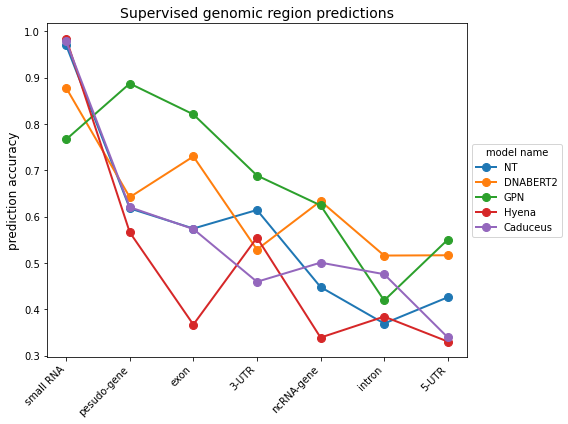

In [25]:
import matplotlib.pyplot as plt
import numpy as np


acc_means_nt = df_acc_nt.mean()
acc_means_gpn = df_acc_gpn.mean()
acc_means_dnabert2 = df_acc_dnabert2.mean()
acc_means_hyena = df_acc_hyena.mean()
acc_means_caduceus = df_acc_caduceus.mean()


def swap_all(x_labels, acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus, a,b):
    def swap(alist, a, b):
        alist[a], alist[b] = alist[b], alist[a]
        return alist
    
    x_labels = swap(x_labels,a,b)
    acc_means_nt = swap(acc_means_nt,a,b)
    acc_means_gpn = swap(acc_means_gpn,a,b)
    acc_means_dnabert2 = swap(acc_means_dnabert2,a,b)
    acc_means_hyena = swap(acc_means_hyena,a,b)
    acc_means_caduceus = swap(acc_means_caduceus,a,b)

    return x_labels, acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus
    
# Data to plot (you can replace this with your own data)
x_labels = ['exon', 'intron', '3-UTR', '5-UTR', 'ncRNA-gene','pesudo-gene','small RNA']

x_labels, acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus = swap_all(x_labels, acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus,0,6)
x_labels, acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus = swap_all(x_labels, acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus,1,5)
x_labels, acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus = swap_all(x_labels, acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus,2,6)
x_labels, acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus = swap_all(x_labels, acc_means_nt, acc_means_gpn, acc_means_dnabert2,acc_means_hyena,acc_means_caduceus,3,6)

models = ['NT', 'DNABERT2','GPN', 'Hyena',  'Caduceus']

# acc_means_nt,acc_means_gpn,acc_means_dnabert2,acc_means_hyena,acc_means_caduceus
data = {
    'NT': acc_means_nt,
    'DNABERT2': acc_means_dnabert2,
    'GPN': acc_means_gpn,
    'Hyena': acc_means_hyena,
    'Caduceus': acc_means_caduceus
}
# Create x positions for the different models
x = np.arange(len(x_labels))

plt.figure(figsize=(8, 6))

# Assign different colors to the models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 'o', 'o', 'o', 'o']

for i, (model, values) in enumerate(data.items()):
    plt.plot(x, values, label=model, marker=markers[i], color=colors[i], linewidth=2, markersize=8)

# Set the x-axis ticks and labels
plt.xticks(x, x_labels, rotation=45, ha='right', fontsize=10)

# Add title and labels
plt.title('Supervised genomic region predictions', fontsize=14)
# plt.xlabel('Model Type', fontsize=12)
plt.ylabel('prediction accuracy', fontsize=12)

# Display legend on the right side of the plot
plt.legend(title='model name', loc='center left', bbox_to_anchor=(1, 0.5))


# Show the plot
plt.savefig('genomic-region-predictions.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()